In [2]:
import pandas as pd  # Veri işleme
import numpy as np  # Sayısal işlemler
import matplotlib.pyplot as plt  # Veri görselleştirme
import seaborn as sns  # İstatistiksel veri görselleştirme
import gc

In [4]:
games = pd.read_csv('games.csv')
recommendations = pd.read_csv('recommendations.csv')
users = pd.read_csv('users.csv')

In [6]:
print("games.csv başlıkları:", list(games.columns))

games.csv başlıkları: ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']


In [8]:
print("recommendations.csv başlıkları:", list(recommendations.columns))

recommendations.csv başlıkları: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id']


In [10]:
print("users.csv başlıkları:", list(users.columns))

users.csv başlıkları: ['user_id', 'products', 'reviews']


In [12]:
print("games.csv veri tipleri:\n", games.dtypes)

games.csv veri tipleri:
 app_id              int64
title              object
date_release       object
win                  bool
mac                  bool
linux                bool
rating             object
positive_ratio      int64
user_reviews        int64
price_final       float64
price_original    float64
discount          float64
steam_deck           bool
dtype: object


In [14]:
print("\nrecommendations.csv veri tipleri:\n", recommendations.dtypes)


recommendations.csv veri tipleri:
 app_id              int64
helpful             int64
funny               int64
date               object
is_recommended       bool
hours             float64
user_id             int64
review_id           int64
dtype: object


In [16]:
print("\nusers.csv veri tipleri:\n", users.dtypes)


users.csv veri tipleri:
 user_id     int64
products    int64
reviews     int64
dtype: object


In [18]:
# recommendations.csv'deki date sütununu datetime formatına çevir
recommendations['date'] = pd.to_datetime(recommendations['date'], errors='coerce')

In [20]:
# date sütunundaki hatalı dönüşümleri kontrol et (NaT olanlar)
print("Date sütununda hatalı dönüşüm (NaT) sayısı:", recommendations['date'].isnull().sum())

Date sütununda hatalı dönüşüm (NaT) sayısı: 0


In [24]:
# 1. Recommendations ve Users'ı user_id üzerinden birleştir
merged_users_recommendations = pd.merge(
    recommendations,
    users,
    on='user_id',
    how='inner'
)

# 2. Yukarıdaki veri setini Games ile app_id üzerinden birleştir
merged_dataset = pd.merge(
    merged_users_recommendations,
    games,
    on='app_id',
    how='inner'
)

# 3. Birleştirilmiş veri setinin boyutunu ve örnek bir kısmını görüntüle
print(f"Birleştirilmiş Veri Seti Boyutu: {merged_dataset.shape}")
print(merged_dataset.head())

Birleştirilmiş Veri Seti Boyutu: (41154794, 22)
    app_id  helpful  funny       date  is_recommended  hours  user_id  \
0   975370        0      0 2022-12-12            True   36.3    51580   
1   304390        4      0 2017-02-17           False   11.5     2586   
2  1085660        2      0 2019-11-17            True  336.5   253880   
3   703080        0      0 2022-09-23            True   27.4   259432   
4   526870        0      0 2021-01-10            True    7.9    23869   

   review_id  products  reviews  ...   win    mac  linux  \
0          0        28        5  ...  True  False  False   
1          1       269        1  ...  True  False  False   
2          2       237        2  ...  True  False  False   
3          3         5        2  ...  True  False  False   
4          4        13        2  ...  True  False  False   

                    rating  positive_ratio user_reviews  price_final  \
0  Overwhelmingly Positive              95        19665         30.0   
1       

In [26]:
print("users.csv başlıkları:", list(merged_dataset.columns))

users.csv başlıkları: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id', 'products', 'reviews', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']


In [28]:
print("\nusers.csv veri tipleri:\n", merged_dataset.dtypes)


users.csv veri tipleri:
 app_id                     int64
helpful                    int64
funny                      int64
date              datetime64[ns]
is_recommended              bool
hours                    float64
user_id                    int64
review_id                  int64
products                   int64
reviews                    int64
title                     object
date_release              object
win                         bool
mac                         bool
linux                       bool
rating                    object
positive_ratio             int64
user_reviews               int64
price_final              float64
price_original           float64
discount                 float64
steam_deck                  bool
dtype: object


In [42]:
# 1. Gereksiz kolonları çıkar
columns_to_drop = ["helpful", "funny", "price_final", "steam_deck", "discount", "mac", "linux", "date"]
merged_dataset = merged_dataset.drop(columns=columns_to_drop, axis=1)

# 2. 100 incelemeden daha az incelemesi olan oyunları çıkar
merged_dataset = merged_dataset[merged_dataset['user_reviews'] >= 100]

# 3. 3 incelemeden daha az inceleme yazmış kullanıcıları çıkar
user_review_counts = merged_dataset.groupby('user_id')['review_id'].count()
users_to_keep = user_review_counts[user_review_counts >= 3].index
merged_dataset = merged_dataset[merged_dataset['user_id'].isin(users_to_keep)]

# 4. 1 saatten daha az oynanmış oyun incelemelerini çıkar
merged_dataset = merged_dataset[merged_dataset['hours'] >= 1]

# 5. 3 dolardan daha ucuz ve 50 dolardan daha pahalı oyunları çıkar
merged_dataset = merged_dataset[(merged_dataset['price_original'] >= 3) & (merged_dataset['price_original'] <= 50)]

# Temizlik sonrası veri setinin boyutlarını kontrol et
print(f"Temizlik sonrası veri seti boyutları: {merged_dataset.shape}")

Temizlik sonrası veri seti boyutları: (10538885, 14)


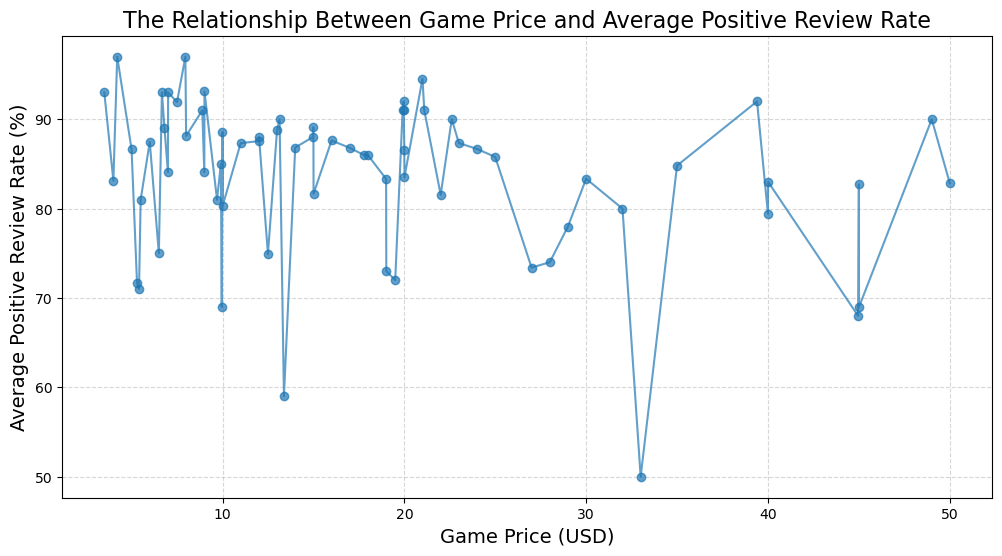

In [70]:
# Oyun fiyatına göre ortalama olumlu yorum oranını hesapla
price_grouped = merged_dataset.groupby('price_original')['positive_ratio'].mean()

# Gruplanmış veriyi çizgi grafiğinde görselleştir
plt.figure(figsize=(12, 6))
plt.plot(price_grouped.index, price_grouped.values, marker='o', linestyle='-', alpha=0.7)

# Grafik detaylarını ekle
plt.title('The Relationship Between Game Price and Average Positive Review Rate', fontsize=16)
plt.xlabel('Game Price (USD)', fontsize=14)
plt.ylabel('Average Positive Review Rate (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

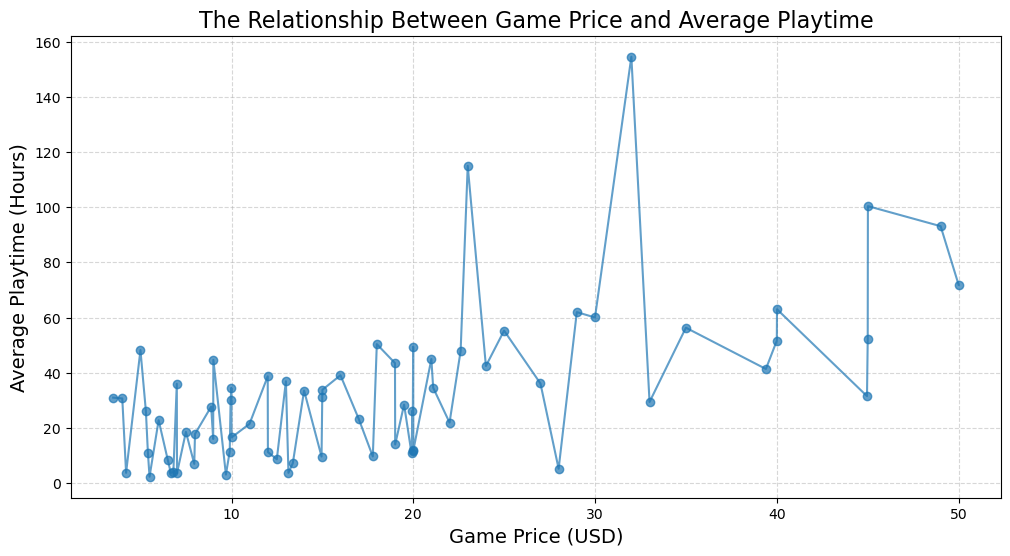

In [72]:
# Oyun fiyatına göre ortalama oynama süresi hesapla
price_hours_grouped = merged_dataset.groupby('price_original')['hours'].mean()

# Gruplanmış veriyi çizgi grafiğinde görselleştir
plt.figure(figsize=(12, 6))
plt.plot(price_hours_grouped.index, price_hours_grouped.values, marker='o', linestyle='-', alpha=0.7)

# Grafik detaylarını ekle
plt.title('The Relationship Between Game Price and Average Playtime', fontsize=16)
plt.xlabel('Game Price (USD)', fontsize=14)
plt.ylabel('Average Playtime (Hours)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

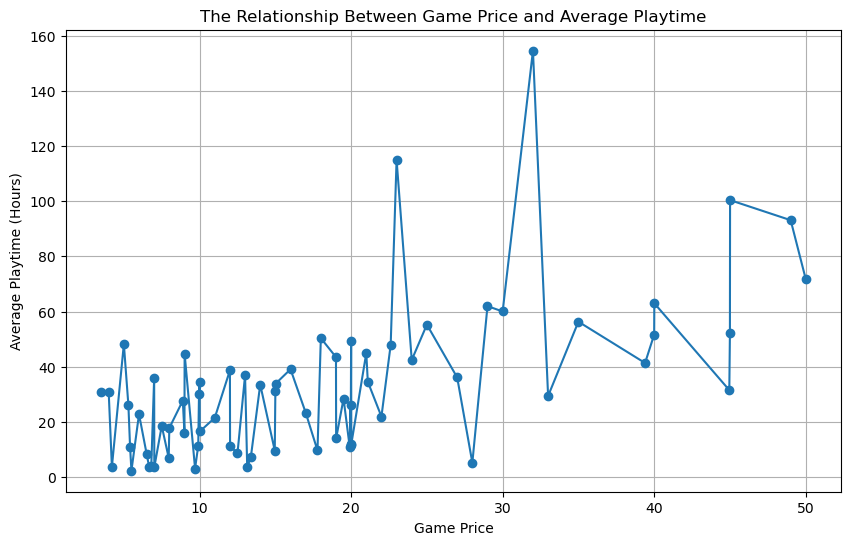

In [74]:
# price_original'i aynı olan oyunların ortalama hours değerlerini hesapla
average_hours_by_price = merged_dataset.groupby('price_original')['hours'].mean()

# Çizgi grafiği oluştur
plt.figure(figsize=(10, 6))
plt.plot(average_hours_by_price.index, average_hours_by_price.values, marker='o')
plt.title('The Relationship Between Game Price and Average Playtime')
plt.xlabel('Game Price')
plt.ylabel('Average Playtime (Hours)')
plt.grid(True)
plt.show()

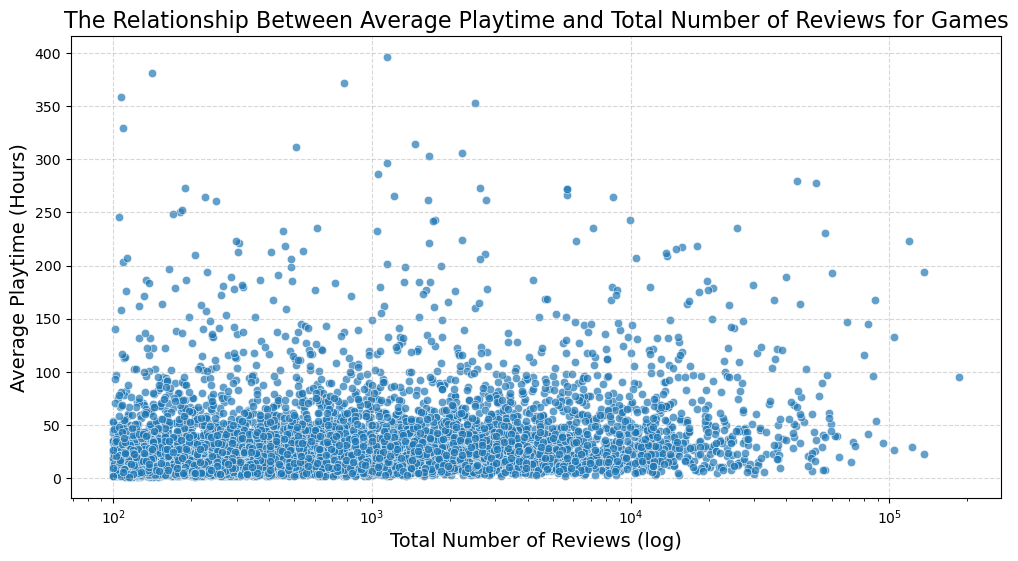

In [76]:
# Oyun başına ortalama oynanma süresi hesapla
avg_hours = merged_dataset.groupby('app_id')['hours'].mean()

# Oyun başına toplam inceleme sayısını al
review_counts = merged_dataset[['app_id', 'user_reviews']].drop_duplicates().set_index('app_id')['user_reviews']

# Ortalama oynanma süresi ve inceleme sayısını birleştir
comparison_data = pd.DataFrame({'avg_hours': avg_hours, 'review_counts': review_counts}).dropna()

# Scatter plot oluştur
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=comparison_data['review_counts'],
    y=comparison_data['avg_hours'],
    alpha=0.7
)

# Grafik detaylarını ekle
plt.xscale('log')  # İnceleme sayısının geniş aralığı için log-scale kullan
plt.title('The Relationship Between Average Playtime and Total Number of Reviews for Games', fontsize=16)
plt.xlabel('Total Number of Reviews (log)', fontsize=14)
plt.ylabel('Average Playtime (Hours)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

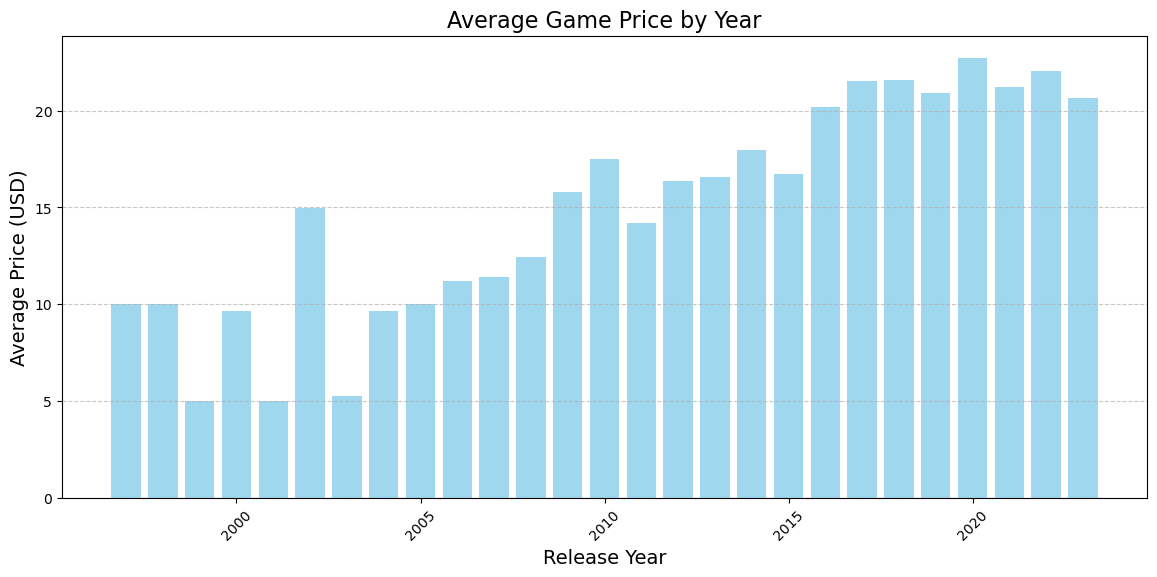

In [78]:
# Yayınlanma tarihini datetime formatına çevir
merged_dataset['date_release'] = pd.to_datetime(merged_dataset['date_release'], errors='coerce')

# Çıkış yılını al
merged_dataset['release_year'] = merged_dataset['date_release'].dt.year

# Çıkış yıllarına göre ortalama fiyatı hesapla
yearly_price_avg = merged_dataset.groupby('release_year')['price_original'].mean()

# Bar chart ile görselleştir
plt.figure(figsize=(14, 6))
plt.bar(yearly_price_avg.index, yearly_price_avg.values, color='skyblue', alpha=0.8)

# Grafik detaylarını ekle
plt.title('Average Game Price by Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Price (USD)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

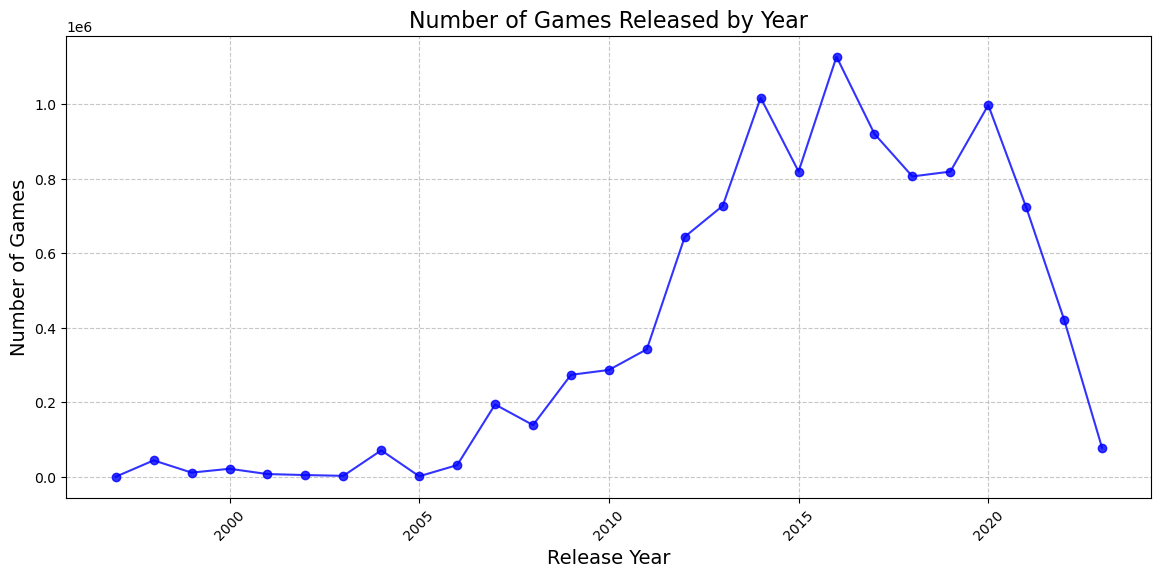

In [80]:
# Yayınlanma tarihini datetime formatına çevir
merged_dataset['date_release'] = pd.to_datetime(merged_dataset['date_release'], errors='coerce')

# Çıkış yılını al
merged_dataset['release_year'] = merged_dataset['date_release'].dt.year

# Yıllara göre oyun sayısını hesapla
yearly_game_count = merged_dataset['release_year'].value_counts().sort_index()

# Çizgi grafiği ile görselleştir
plt.figure(figsize=(14, 6))
plt.plot(yearly_game_count.index, yearly_game_count.values, marker='o', linestyle='-', color='blue', alpha=0.8)

# Grafik detaylarını ekle
plt.title('Number of Games Released by Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

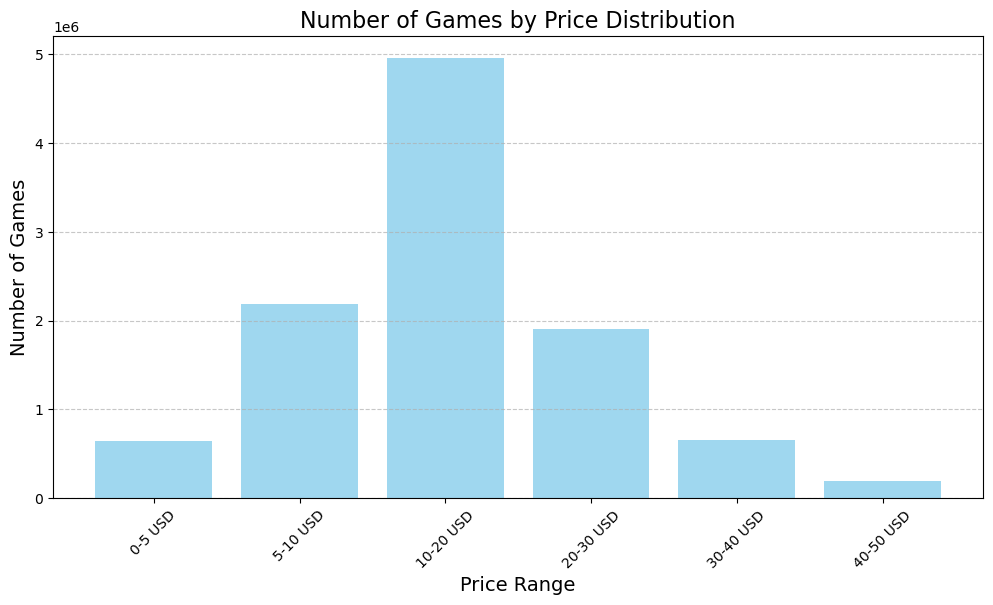

In [82]:
# Fiyat aralıklarını belirle
price_bins = [0, 5, 10, 20, 30, 40, 50]  # Fiyat aralıkları
price_labels = ['0-5 USD', '5-10 USD', '10-20 USD', '20-30 USD', '30-40 USD', '40-50 USD']

# Fiyatları aralıklara ayır
merged_dataset['price_range'] = pd.cut(merged_dataset['price_original'], bins=price_bins, labels=price_labels)

# Her fiyat aralığındaki oyun sayısını hesapla
price_distribution = merged_dataset['price_range'].value_counts().sort_index()

# Sütun grafiği ile görselleştir
plt.figure(figsize=(12, 6))
plt.bar(price_distribution.index, price_distribution.values, color='skyblue', alpha=0.8)

# Grafik detaylarını ekle
plt.title('Number of Games by Price Distribution', fontsize=16)
plt.xlabel('Price Range', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

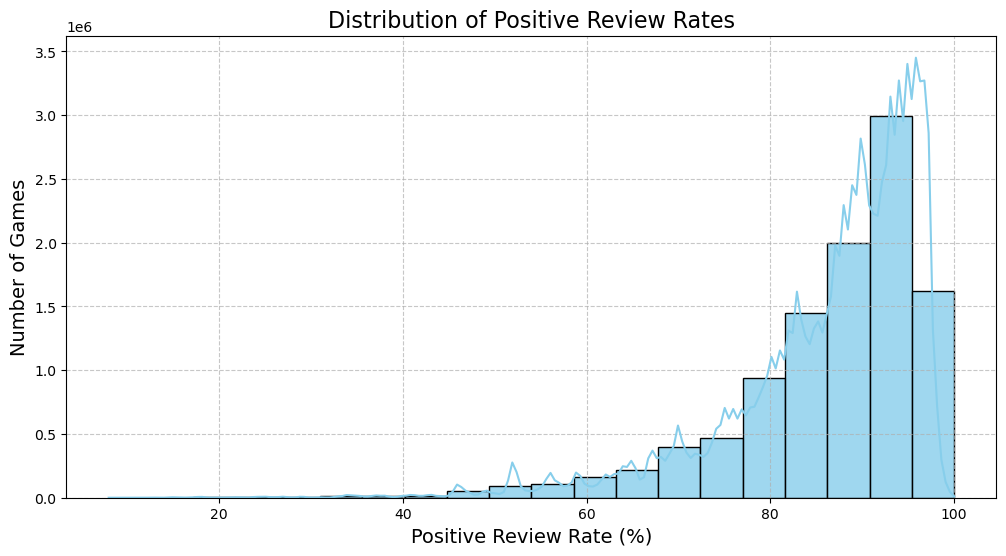

In [84]:
# Histogram ile olumlu inceleme oranlarının dağılımını çiz
plt.figure(figsize=(12, 6))
sns.histplot(merged_dataset['positive_ratio'], bins=20, kde=True, color='skyblue', alpha=0.8)

# Grafik detaylarını ekle
plt.title('Distribution of Positive Review Rates', fontsize=16)
plt.xlabel('Positive Review Rate (%)', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

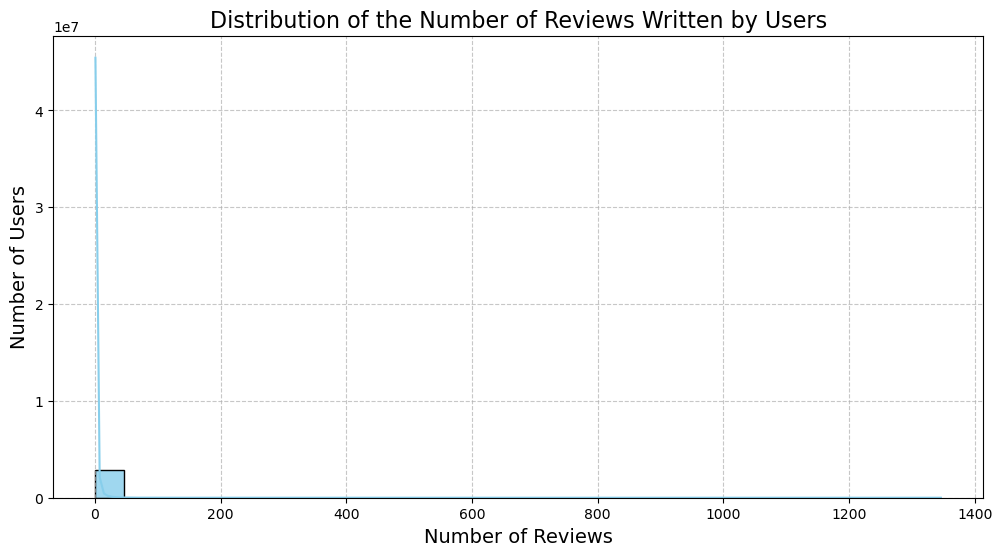

In [85]:
# Kullanıcı başına toplam inceleme sayısını hesapla
user_review_counts = merged_dataset.groupby('user_id')['review_id'].count()

# Histogram ile inceleme dağılımını görselleştir
plt.figure(figsize=(12, 6))
sns.histplot(user_review_counts, bins=30, kde=True, color='skyblue', alpha=0.8)

# Grafik detaylarını ekle
plt.title('Distribution of the Number of Reviews Written by Users', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

50'den fazla inceleme yapan kullanıcı sayısı: 9406


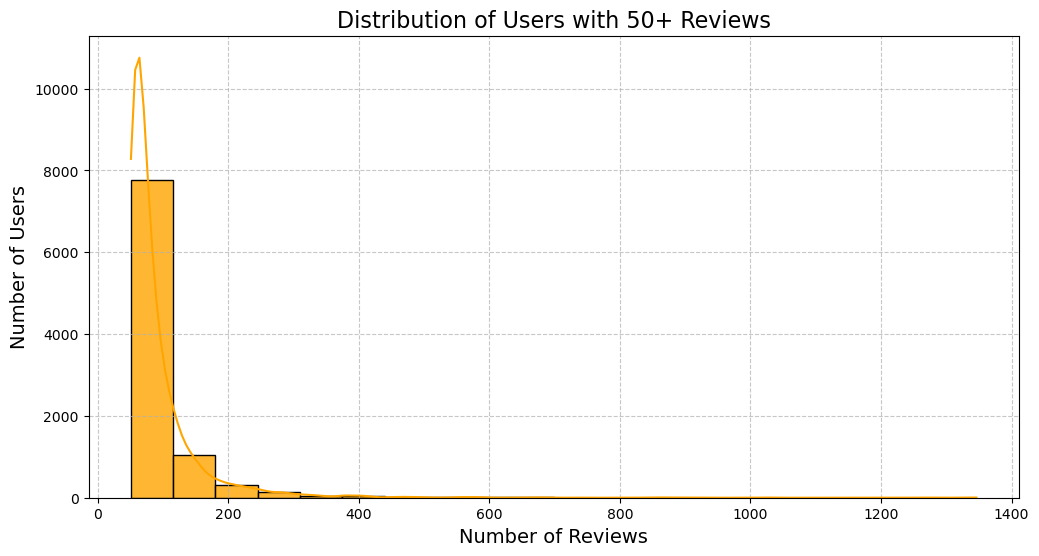

In [86]:
# Çok sayıda inceleme yazan kullanıcıları seç
active_users = user_review_counts[user_review_counts > 50]  # Örneğin, 50'den fazla inceleme yazanlar

# Aktif kullanıcı sayısını yazdır
print(f"50'den fazla inceleme yapan kullanıcı sayısı: {len(active_users)}")

# Bar chart ile görselleştir
plt.figure(figsize=(12, 6))
sns.histplot(active_users, bins=20, kde=True, color='orange', alpha=0.8)
plt.title('Distribution of Users with 50+ Reviews', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [90]:
# İnceleme sayısının ortalamasını ve standart sapmasını hesapla
mean_reviews = games['user_reviews'].mean()
std_reviews = games['user_reviews'].std()

# Alt ve üst sınır belirle (örneğin, 1 standart sapma)
lower_limit = mean_reviews - std_reviews
upper_limit = mean_reviews + std_reviews

print(f"Alt Sınır: {lower_limit}, Üst Sınır: {upper_limit}")

Alt Sınır: -38249.09666505362, Üst Sınır: 41897.946641465


In [92]:
# Yüzdelik dilimleri hesapla
lower_percentile = games['user_reviews'].quantile(0.10)  # 10. yüzdelik
print(f"10. Yüzdelik Sınırı: {lower_percentile}")

10. Yüzdelik Sınırı: 12.0


Medyan: 10662.0, Filtreleme Eşiği: 21324.0


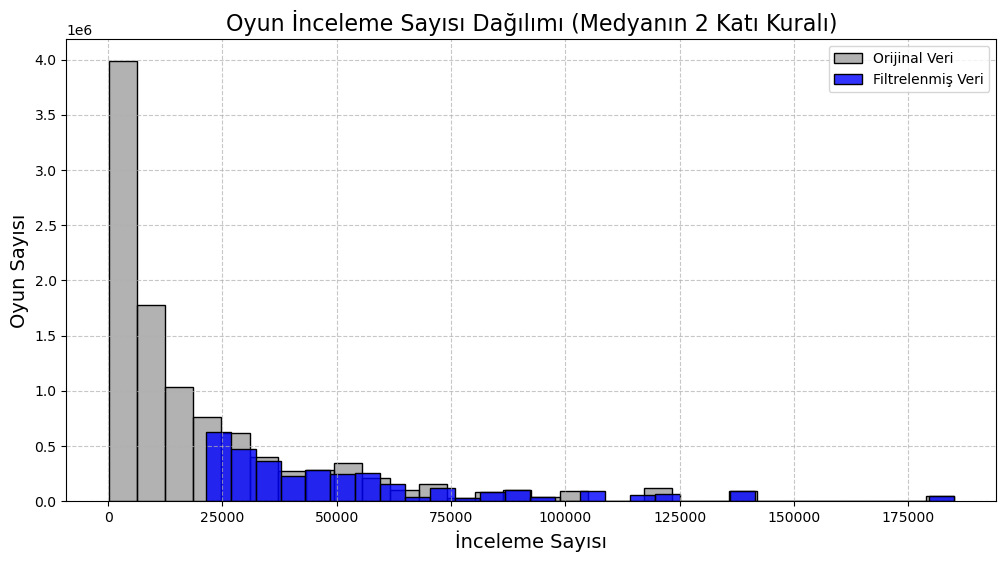

In [98]:
# Medyanı hesapla
median_reviews = merged_dataset['user_reviews'].median()
filter_threshold = median_reviews * 2
print(f"Medyan: {median_reviews}, Filtreleme Eşiği: {filter_threshold}")

# Filtreleme (medyanın 2 katından az inceleme alan oyunları çıkar)
filtered_dataset = merged_dataset[merged_dataset['user_reviews'] >= filter_threshold]

# Görselleştirme: Filtrelenmiş ve orijinal veri
plt.figure(figsize=(12, 6))

# Orijinal veri dağılımı
sns.histplot(merged_dataset['user_reviews'], bins=30, color='gray', label='Orijinal Veri', alpha=0.6)

# Filtrelenmiş veri dağılımı
sns.histplot(filtered_dataset['user_reviews'], bins=30, color='blue', label='Filtrelenmiş Veri', alpha=0.8)

# Grafik detayları
plt.title('Oyun İnceleme Sayısı Dağılımı (Medyanın 2 Katı Kuralı)', fontsize=16)
plt.xlabel('İnceleme Sayısı', fontsize=14)
plt.ylabel('Oyun Sayısı', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()